# EM Angular Two-point Correlation Function

## Fig 6.X

In [1]:
"""
Angular Two-point Correlation Function
--------------------------------------
Figure 6.17

The two-point correlation function of SDSS spectroscopic galaxies in the range
0.08 < z < 0.12, with m < 17.7. This is the same sample for which the
luminosity function is computed in figure 4.10. Errors are estimated using ten
bootstrap samples. Dotted lines are added to guide the eye and correspond to a
power law proportional to :math:`\theta^{-0.8}`. Note that the red galaxies
(left panel) are clustered more strongly than the blue galaxies (right panel).
"""

'\nAngular Two-point Correlation Function\n--------------------------------------\nFigure 6.17\n\nThe two-point correlation function of SDSS spectroscopic galaxies in the range\n0.08 < z < 0.12, with m < 17.7. This is the same sample for which the\nluminosity function is computed in figure 4.10. Errors are estimated using ten\nbootstrap samples. Dotted lines are added to guide the eye and correspond to a\npower law proportional to :math:`\theta^{-0.8}`. Note that the red galaxies\n(left panel) are clustered more strongly than the blue galaxies (right panel).\n'

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular


In [3]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

#------------------------------------------------------------

In [4]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

In [5]:
N=10
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [11]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


# Get data and do some quality cuts

In [7]:
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))


data size:
  red gals:  38017
  blue gals: 16883


In [18]:
data_red.shape

(38017,)

In [19]:
data_blue.shape

(16883,)

# Set up correlation function computation

In [8]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

In [9]:
(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

@pickle_results: using precomputed results from 'correlation_functions.pkl'


# Plot the results

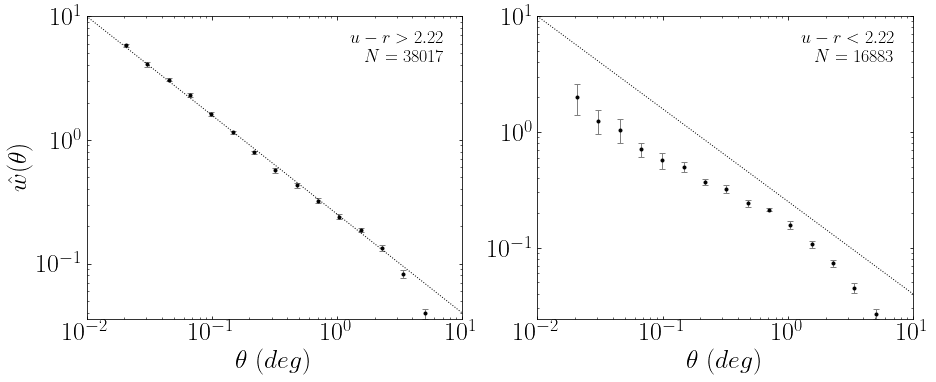

In [16]:
#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()